In [1]:
from random import seed

import numpy as np
from numpy.random import seed as np_seed
import ase
from ase.cluster.cubic import FaceCenteredCubic
import matplotlib.pyplot as plt

In [2]:
from clusterx.parent_lattice import ParentLattice
from clusterx.super_cell import SuperCell
from clusterx.structures_set import StructuresSet
from clusterx.calculators.emt import EMT2
from clusterx.clusters.clusters_pool import ClustersPool
from clusterx.model import ModelBuilder

In [3]:
from clusterx.visualization import plot_optimization_vs_number_of_clusters
from clusterx.visualization import plot_predictions_vs_target
from clusterx.visualization import plot_property_vs_concentration
from clusterx.visualization import juview

# Cluster expansion of a nanoparticle

In this tutorial we will generate a cluster expansion model for predicting the energy of a (finite) Cu-Ni nano-particle.

## Creation of the parent lattice 

In the first step, we use `ASE`s `build` module to generate atomic configuration for the parent lattice.

In [4]:
# from https://wiki.fysik.dtu.dk/ase/ase/cluster/cluster.html
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [3, 3, 3]
lc = 3.61000
Cu_atoms = FaceCenteredCubic('Cu', surfaces, layers, latticeconstant=lc)
Ni_atoms = FaceCenteredCubic('Ni', surfaces, layers, latticeconstant=lc)

These structures are generated without a simulation cell. Therefore we create one:

In [5]:
Cu_atoms.set_cell(np.eye(3) * 4 * lc)
Ni_atoms.set_cell(np.eye(3) * 4 * lc)

And shift the atoms to the center of the cell:

In [6]:
Cu_atoms.translate(np.ones((1,3)) * 2 * lc)
Ni_atoms.translate(np.ones((1,3)) * 2 * lc)

Now we can create our parent lattice and super cell objects:

In [7]:
alloy_dot_plat = ParentLattice(Cu_atoms,
                               substitutions=[Ni_atoms])

In [8]:
alloy_dot_scell = SuperCell(parent_lattice=alloy_dot_plat, 
                            p=[1,1,1]) # for a finite system, we need to set the transformation matrix to [1,1,1]

We can visualize the parent lattice using `juview`:

In [9]:
juview(alloy_dot_plat)

## Generation of the structures set

Using our parent lattice, we can generate a structures set and start generating random structures:

In [10]:
alloy_dot_sset = StructuresSet(parent_lattice=alloy_dot_plat, 
                               calculator=EMT2()) # we use the EMT calculator here to approximate the total energy

In [11]:
# To ensure reproducibility, we set the seed of all random number generators to 0
seed(0), np_seed(0)

for nsubs in range(0,len(Cu_atoms)+1): # for each possible number of substituents
    if nsubs in [0, len(Cu_atoms)+1]: # for the pristine structures, generate one struture
        alloy_dot_sset.add_structure(alloy_dot_scell.gen_random_structure(nsubs=nsubs))
        continue
    for _ in range(5): # create five structures for all other compositions
        alloy_dot_sset.add_structure(alloy_dot_scell.gen_random_structure(nsubs=nsubs))

Let's plot the first few structures:

In [12]:
juview(alloy_dot_sset, n=9)

The total number of structures is:

In [13]:
len(alloy_dot_sset)

216

Last, we generate energies with the EMT calculator:

In [14]:
energies = alloy_dot_sset.compute_property_values()

and add them to the structures set:

In [15]:
alloy_dot_sset.set_property_values(property_vals=energies, 
                                   update_json_db=False) # We don't serialize anything in this tutorial, so the data update is set to False

## Creation of the clusters pool

For the clusters pool, we pass the parent lattice and the super cell objects:

In [16]:
cpool = ClustersPool(parent_lattice=alloy_dot_plat,
                     super_cell=alloy_dot_scell,
                     npoints=[1,2,3], # generate up to 3 point clusters
                     radii=[-1,-1,3]) # include all 1 and 2 point clusters, and 3 point clusters up to 3 A

We can print information about the clusters pool:

In [17]:
_ = cpool.print_info()


+-------------------------------------------------------------------------------+
|                             Clusters Pool Info                                |
+-------------------------------------------------------------------------------+
|       Index       |   Nr. of points   |      Radius       |   Multiplicity    |
+-------------------------------------------------------------------------------+
|         0         |         1         |       0.000       |        24         |
|         1         |         1         |       0.000       |        12         |
|         2         |         1         |       0.000       |         6         |
|         3         |         1         |       0.000       |         1         |
|         4         |         2         |       2.553       |        24         |
|         5         |         2         |       2.553       |        48         |
|         6         |         2         |       2.553       |        24         |
|         7    

## Building a cluster expansion model

To build the model, we can make use of the `ModelBuilder` class. For this tutorial, we select clusters with linear regression, based on their size. 

For a more detailed example on how to create a model, we refer to the tutorial on finding the optimal CE model.

In [18]:
mb = ModelBuilder(selector_type="linreg",
                  selector_opts={'clusters_sets':'size'},
                  estimator_type="skl_LinearRegression",
                  estimator_opts={"fit_intercept":True})

cemodel = mb.build(alloy_dot_sset, cpool, "total_energy") #Build CE model using the training data set
cpool_opt = mb.get_opt_cpool()

We can see that the fit and CV errors are very similar by printing them: 

In [19]:
cemodel.report_errors(alloy_dot_sset)


+-----------------------------------------------------------+
|                Report of Fit and CV scores                |
+-----------------------------------------------------------+
|                   |        Fit        |        CV         |
+-----------------------------------------------------------+
|       RMSE        |      0.00004      |      0.00005      |
|        MAE        |      0.00003      |      0.00003      |
|       MaxAE       |      0.00010      |      0.00015      |
+-----------------------------------------------------------+



The optimal clusters pool is smaller and contains less 2-point clusters than our original pool.

In [20]:
_ = cpool_opt.print_info(ecis=cemodel.get_ecis())


+---------------------------------------------------------------------------------------------------+
|                                       Clusters Pool Info                                          |
+---------------------------------------------------------------------------------------------------+
|       Index       |   Nr. of points   |      Radius       |   Multiplicity    |        ECI        |
+---------------------------------------------------------------------------------------------------+
|         0         |         1         |       0.000       |        24         |      5.2346       |
|         1         |         1         |       0.000       |        12         |      0.8750       |
|         2         |         1         |       0.000       |         6         |      0.9109       |
|         3         |         1         |       0.000       |         1         |      0.0283       |
|         4         |         2         |       2.553       |        24         |

## Visualizing results

Last, we visualize model optimization. In the following plot, we can see the RSME fit and CV errors as a function of the number of clusters. We generate an log scale plot, because the resulting errors span several orders of magnitude.

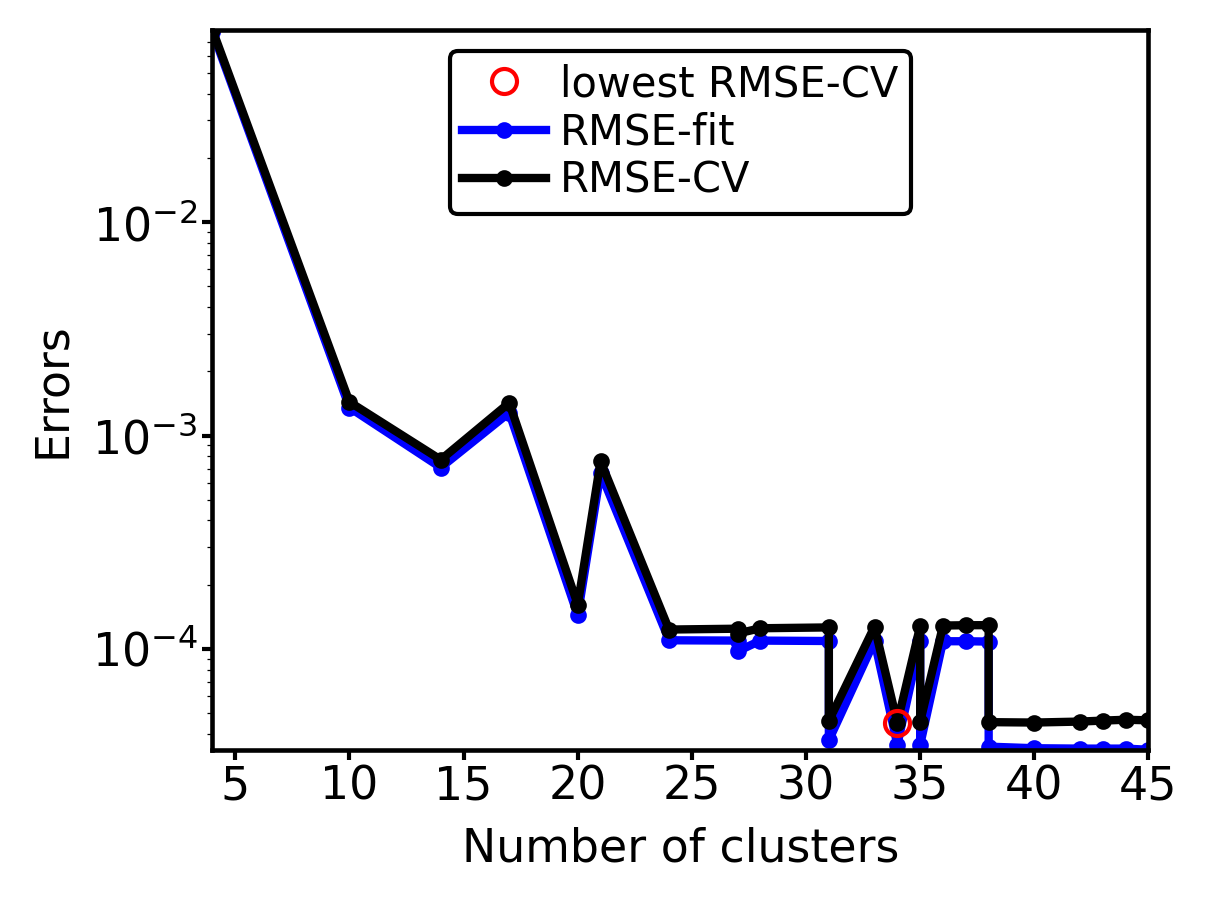

In [21]:
plot_optimization_vs_number_of_clusters(mb.get_selector(),
                                        scale=0.7, 
                                        show_plot=False)
plt.yscale("log")
plt.show()

We can show a parity plot to show how the true and predicted energies relate to each other:

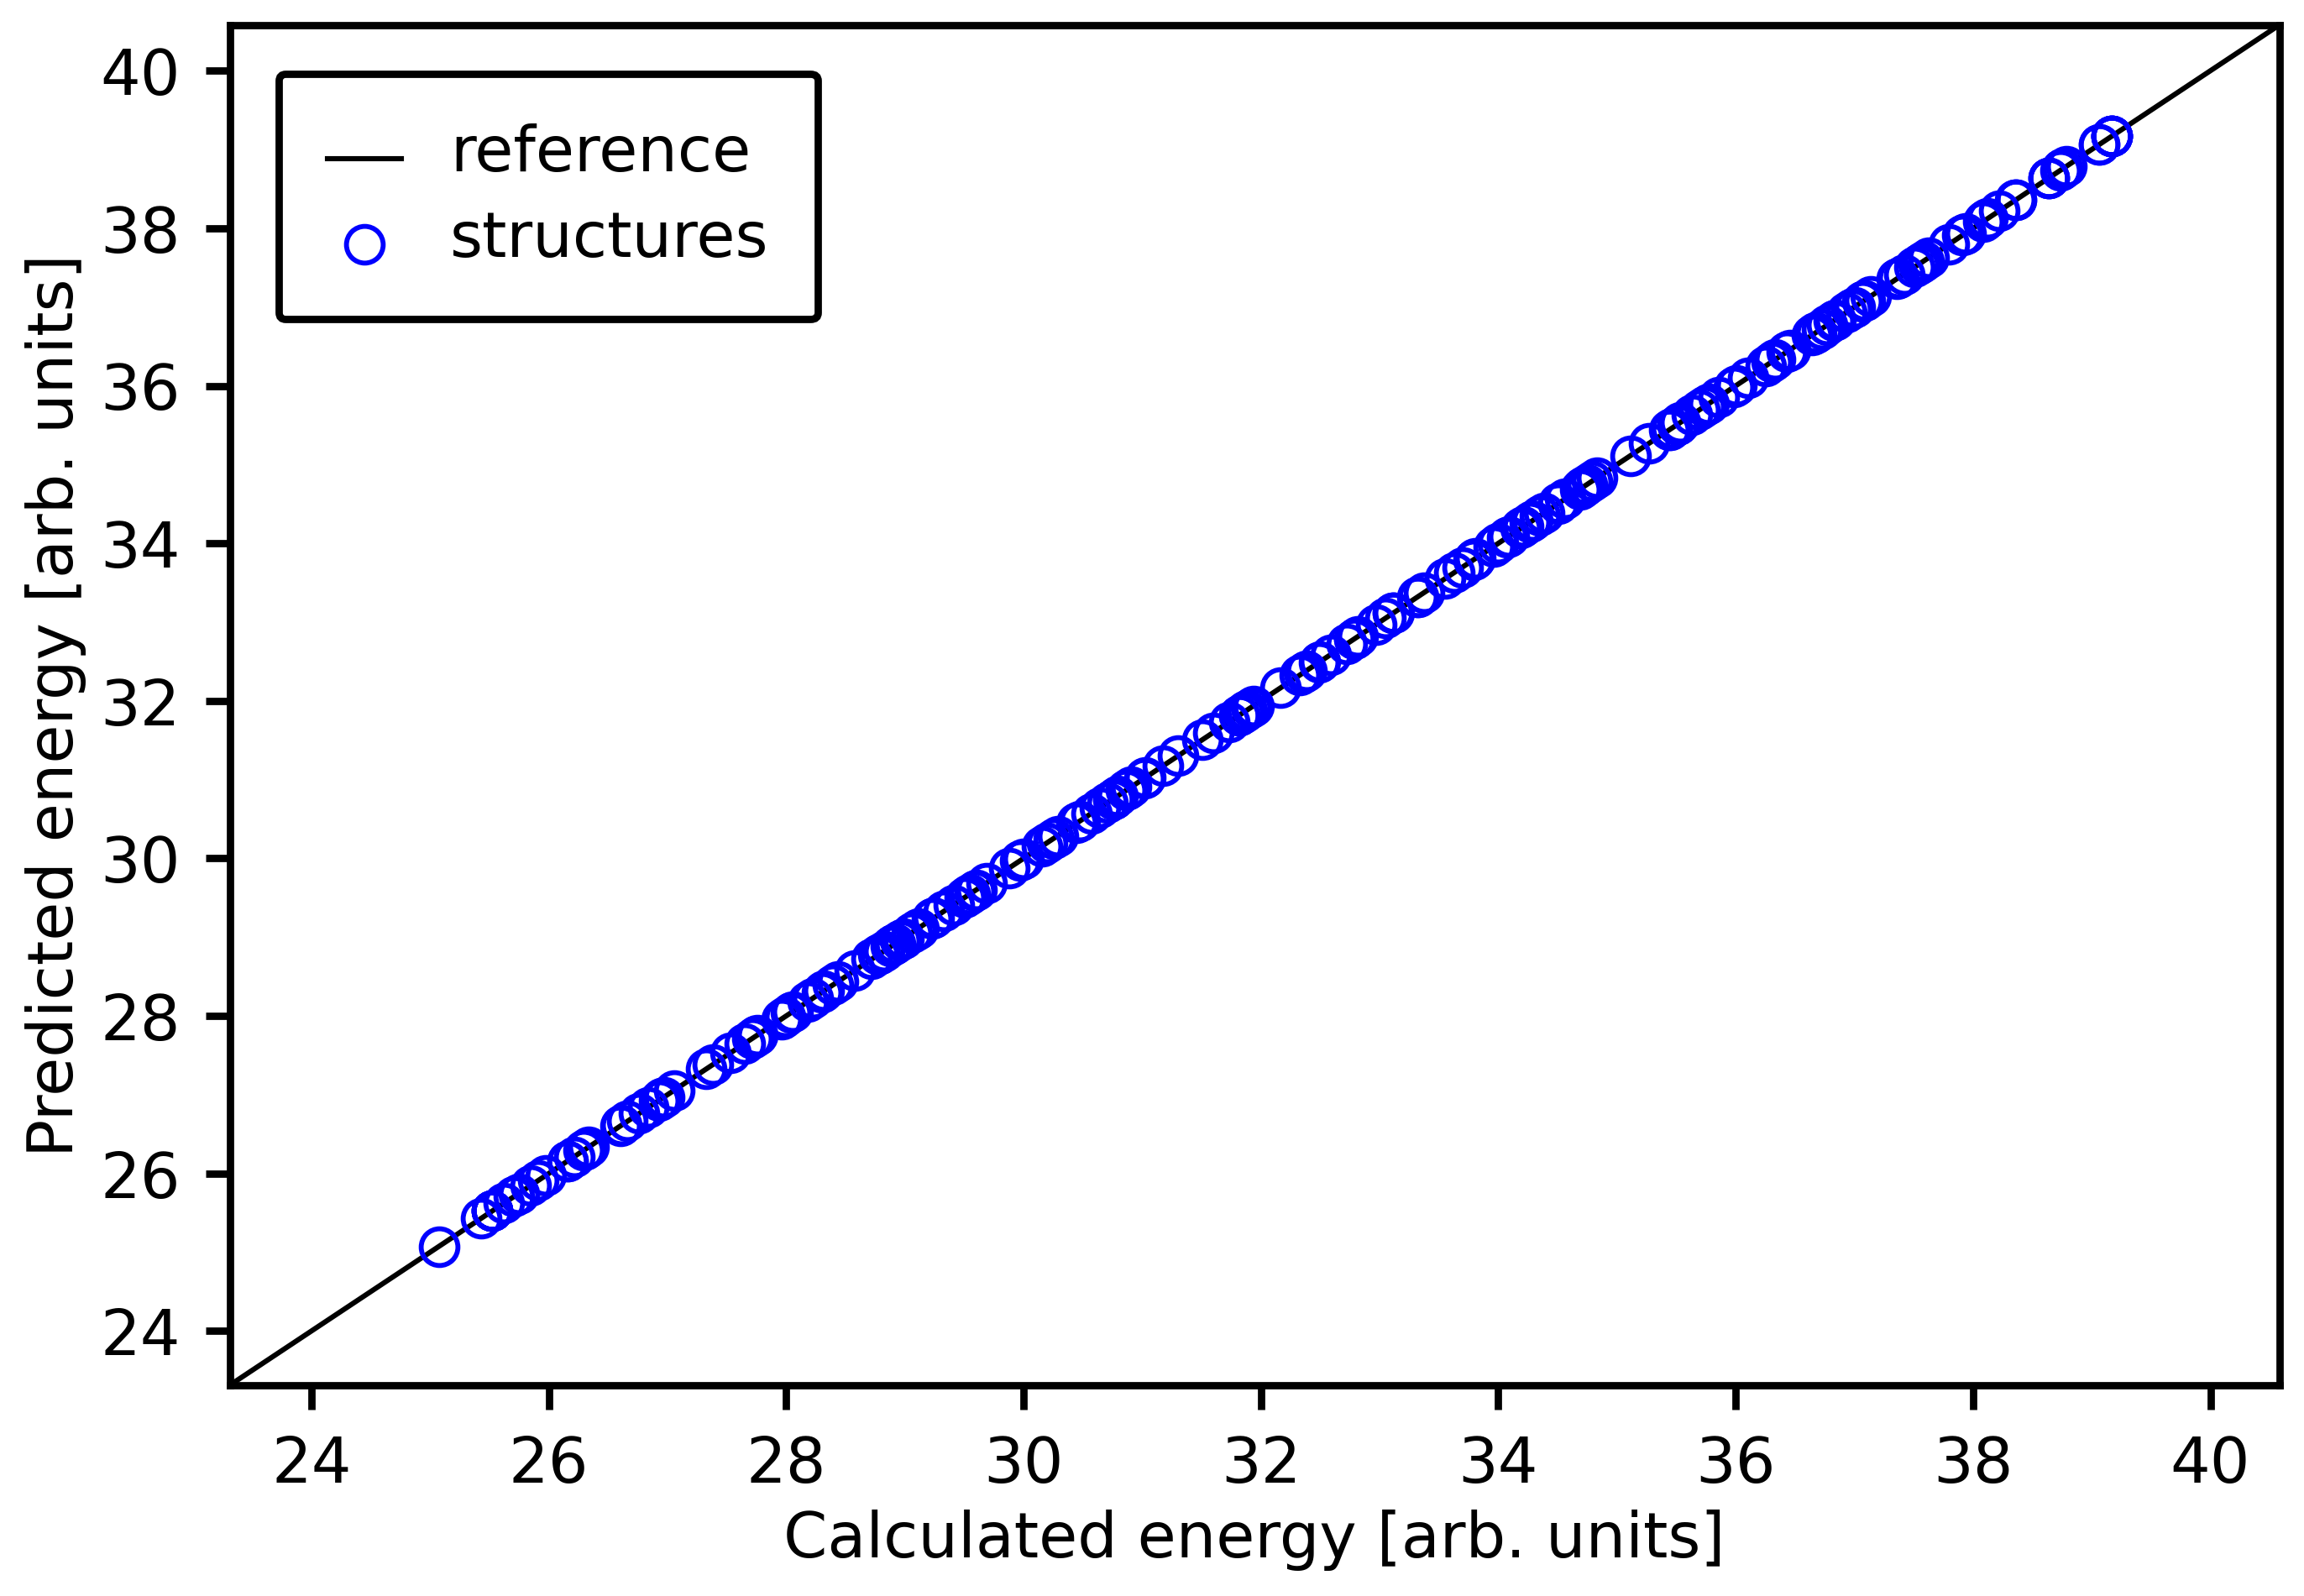

In [23]:
plot_predictions_vs_target(alloy_dot_sset,
                           cemodel,
                           "total_energy",
                           scale=0.7)

Lastly, the property vs concentration plot shows us that the quality of predictions is high over the full configuration range:

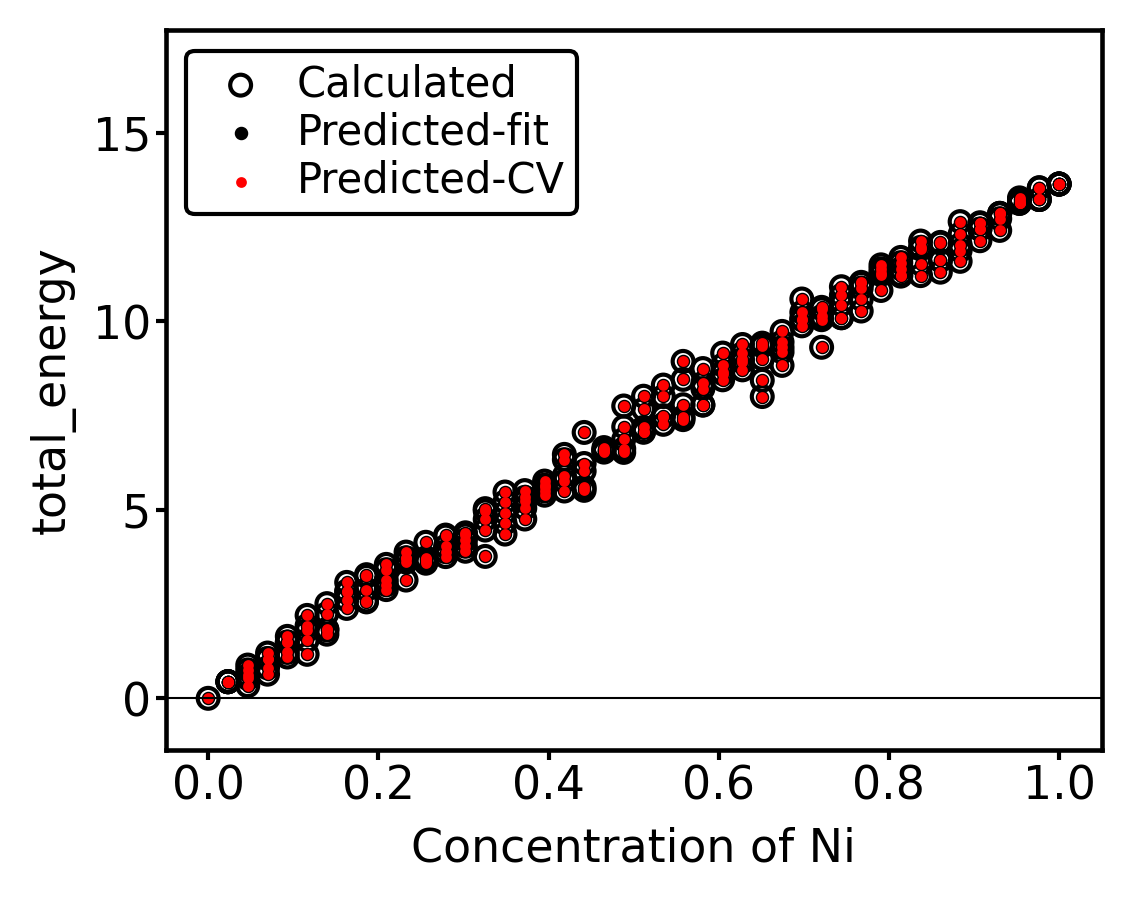

In [24]:
_ = plot_property_vs_concentration(alloy_dot_sset, 
                               site_type=0, 
                               property_name="total_energy",
                               cemodel=cemodel,
                               refs=energies,
                               scale=0.7)